
================ Logistic Regression ================
Accuracy: 0.8055358410220014
ROC-AUC: 0.8418739827946988
Confusion Matrix:
 [[926 109]
 [165 209]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


================ Random Forest ================
Accuracy: 0.7984386089425124
ROC-AUC: 0.8385026737967914
Confusion Matrix:
 [[935 100]
 [184 190]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      14

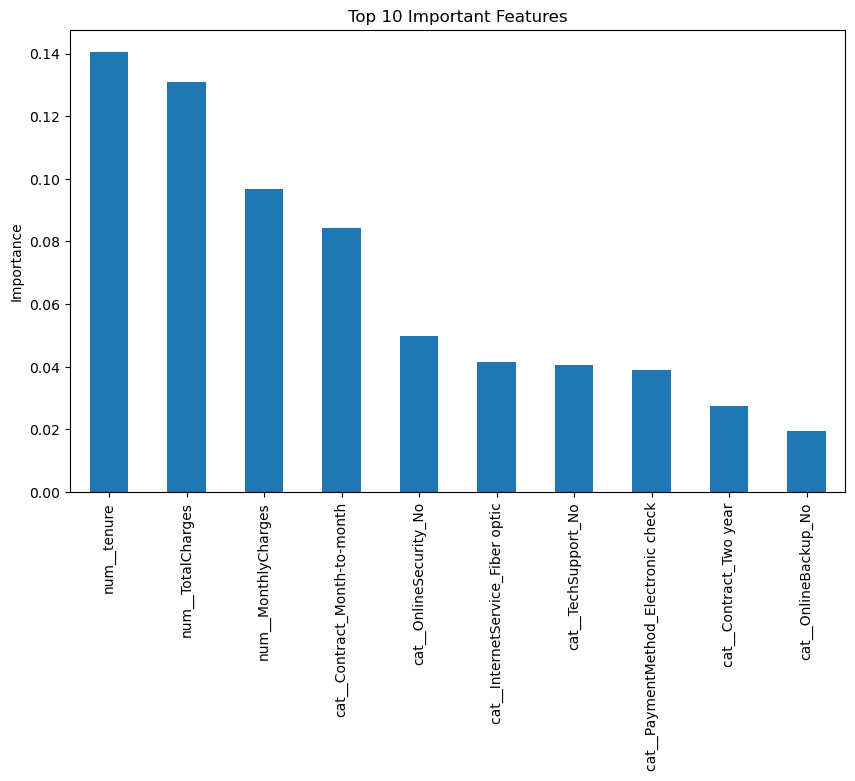

Model saved as churn_model.pkl
churn_powerbi_data.csv created successfully!


In [9]:
# ======================================
# IMPORT LIBRARIES
# ======================================
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib

# ======================================
# LOAD DATA
# ======================================
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop ID
df.drop("customerID", axis=1, inplace=True)

# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Target
y = df['Churn'].map({'Yes': 1, 'No': 0})
X = df.drop("Churn", axis=1)

# Column types
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# ======================================
# PREPROCESSOR
# ======================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# ======================================
# MODELS (TUNED)
# ======================================
lr_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=2000))
])

rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=400,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

xgb_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss'
    ))
])

# ======================================
# SPLIT
# ======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ======================================
# TRAIN & EVALUATE
# ======================================
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n================ {name} ================")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# ======================================
# FEATURE IMPORTANCE (Random Forest)
# ======================================
rf_model.fit(X_train, y_train)

feature_names = rf_model.named_steps['preprocess'].get_feature_names_out()
importances = rf_model.named_steps['model'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(10).plot(kind='bar')
plt.title("Top 10 Important Features")
plt.ylabel("Importance")
plt.show()

# ======================================
# SAVE BEST MODEL (XGBoost)
# ======================================
joblib.dump(xgb_model, "churn_model.pkl")
print("Model saved as churn_model.pkl")
# Add predictions to original dataframe
df_powerbi = df.copy()

df_powerbi['Predicted_Churn'] = lr_model.predict(X)
df_powerbi['Churn_Probability'] = lr_model.predict_proba(X)[:,1]

# Save to CSV for Power BI
df_powerbi.to_csv("churn_powerbi_data.csv", index=False)

print("churn_powerbi_data.csv created successfully!")

